In [97]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline

from sklearn import neighbors
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [99]:
data_train=pd.read_csv("/Users/sarahlee/Downloads/train.csv")
data_test=pd.read_csv("/Users/sarahlee/Downloads/test.csv")

data_train.drop('Employee ID', axis = 1,inplace = True)
data_test.drop('Employee ID', axis = 1,inplace = True)
data_train = data_train.dropna()
data_test = data_test.dropna()

In [101]:
label_encoders = {}
for column in data_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_train[column] = le.fit_transform(data_train[column])
    label_encoders[column] = le

for column in data_test.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        le = label_encoders[column]
        data_test[column] = le.transform(data_test[column])

X_train = data_train.drop('Attrition', axis=1)
y_train = data_train['Attrition']

X_test = data_test.drop('Attrition', axis=1)
y_test = data_test['Attrition']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [103]:
y, X = dmatrices('Attrition ~ Age + Q("Monthly Income") + Q("Job Level") + Q("Years at Company") + ' + 
                 ' + '.join(['Q("' + col + '")' for col in data_train.columns if col not in ['Attrition', 'Employee ID']]), 
                 data=data_train, return_type='dataframe')


In [105]:

knn = KNeighborsClassifier(n_neighbors=5)
# Fit the classifier to the training data
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy

0.6728859060402684

In [106]:
def cv_accuracy_score(X, y, nn):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    accuracies = []
    
    kfold = StratifiedKFold(n_splits=3, shuffle=True).split(X, y)
    for train, holdout in kfold:
        # Select the training and testing data using the indices provided by kfold
        X_train = X[train]
        X_holdout = X[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        accuracy = metrics.accuracy_score(y_holdout, model.predict(X_holdout))
        accuracies.append(accuracy)
    
    average_accuracy = Series(accuracies).mean()
    return average_accuracy

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train_series = pd.Series(y_train)

# Perform cross-validation with different values of k
nn = [1] + [(x + 1) * 5 for x in range(19)]
scores = [cv_accuracy_score(X_train_scaled_df.values, y_train_series.values, num_nbrs) for num_nbrs in nn]


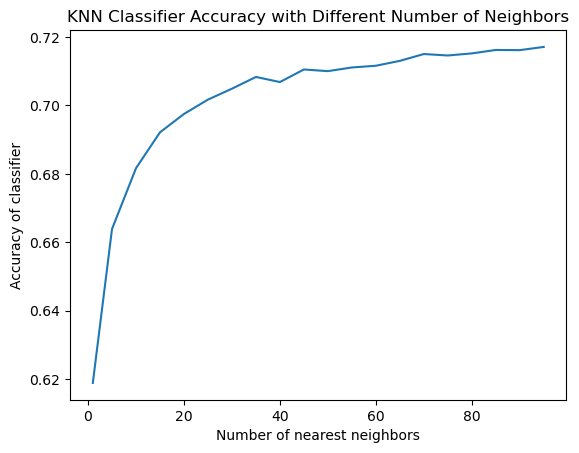

In [108]:
# Plot the cross-validation results
plt.plot(nn, scores)
plt.xlabel('Number of nearest neighbors')
plt.ylabel('Accuracy of classifier')
plt.title('KNN Classifier Accuracy with Different Number of Neighbors')
plt.show()

In [109]:
best_k = nn[scores.index(max(scores))]
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)
best_k

95

In [110]:
# Predict on the test data
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
cv_accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cv_accuracy #notice how the accuracy increased after cross validation 

0.718255033557047

In [115]:

# Calculate the confusion matrix
cv_conf_matrix = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a pandas DataFrame
cv_conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])
cv_conf_matrix_df

,Predicted Negative,Predicted Positive
Actual Negative,4985,2047
Actual Positive,2214,5654


In [125]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

selector = SelectKBest(f_classif, k=20)  # Select the top 20 features
X_train_selected = selector.fit_transform(X_train_poly, y_train)
X_test_selected = selector.transform(X_test_poly)

selected_feature_names = poly.get_feature_names_out(X_train.columns)
top_20_features = selected_feature_names[selector.get_support()]
top_20_scores = selector.scores_[selector.get_support()]
top_20_df = pd.DataFrame({'Feature': top_20_features, 'Score': top_20_scores})

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 253 but corresponding boolean dimension is 22

In [119]:
knn = KNeighborsClassifier(n_neighbors=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='accuracy')

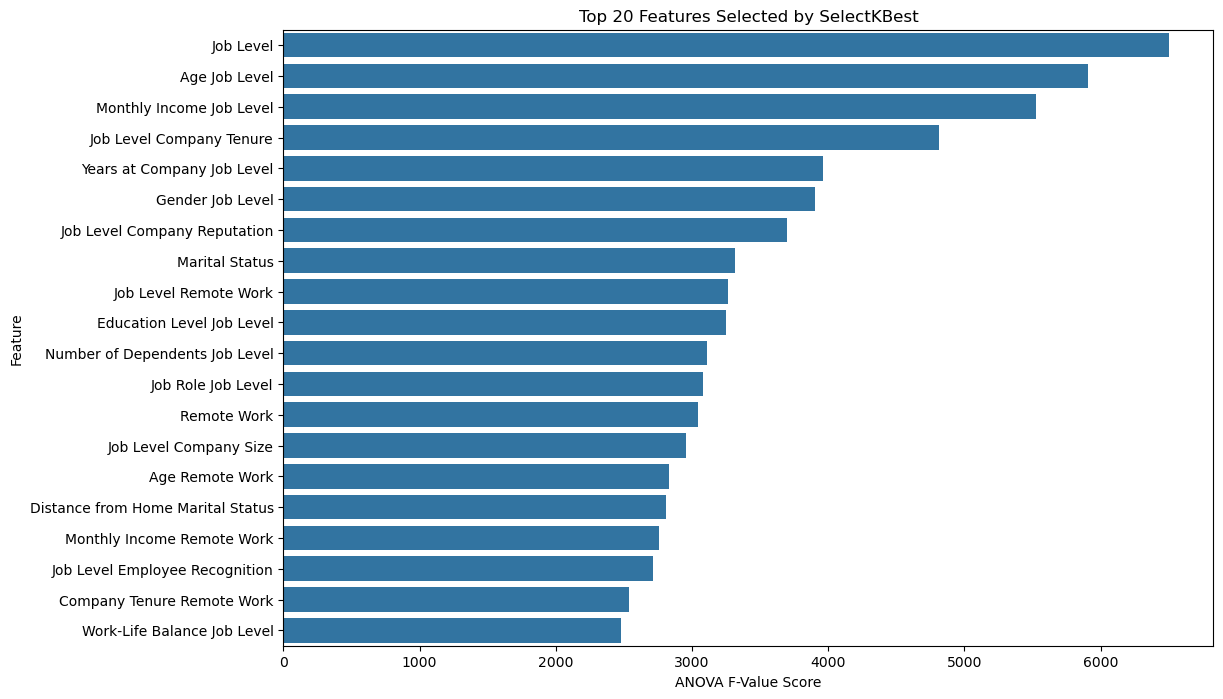

In [120]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=top_20_df.sort_values(by='Score', ascending=False))
plt.title('Top 20 Features Selected by SelectKBest')
plt.xlabel('ANOVA F-Value Score')
plt.ylabel('Feature')
plt.show()


In [121]:
def cv_accuracy_score(X, y, nn):
    """For each fold, fit the nearest neighbors model with nn nearest neighbors on the train, and return accuracy on the test."""
    model = KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    accuracies = []
    
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X, y)
    for train, holdout in kfold:
        X_train, X_holdout = X[train], X[holdout]
        y_train, y_holdout = y[train], y[holdout]
        
        model.fit(X_train, y_train)
        
        accuracy = metrics.accuracy_score(y_holdout, model.predict(X_holdout))
        accuracies.append(accuracy)
    
    average_accuracy = pd.Series(accuracies).mean()
    return average_accuracy
y_train_series = pd.Series(y_train)
nn = [1] + [(x + 1) * 5 for x in range(19)]
scores = [cv_accuracy_score(X_train_scaled, y_train_series.values, num_nbrs) for num_nbrs in nn]


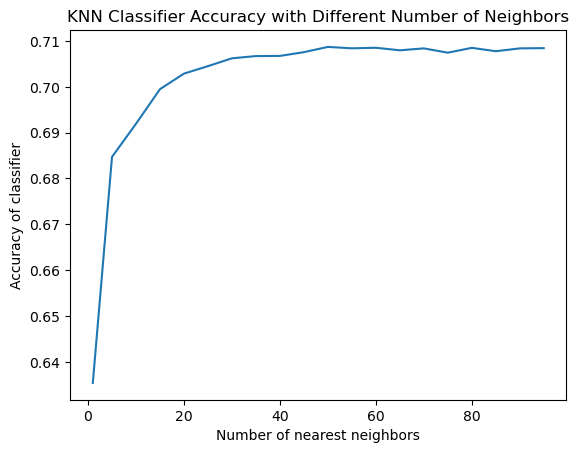

In [28]:
plt.plot(nn, scores)
plt.xlabel('Number of nearest neighbors')
plt.ylabel('Accuracy of classifier')
plt.title('KNN Classifier Accuracy with Different Number of Neighbors')
plt.show()


In [91]:

# Choose the best k from cross-validation and train final model
best_k = nn[scores.index(max(scores))]
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)
print(best_k)


# Predict on the test data
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
selected_accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
selected_accuracy


50


0.7140268456375839

In [93]:
# Calculate the confusion matrix
selected_conf_matrix = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a pandas DataFrame
selected_conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])
selected_conf_matrix_df

,Predicted Negative,Predicted Positive
Actual Negative,4985,2047
Actual Positive,2214,5654


In [75]:
print(accuracy)
print(cv_accuracy)
print(selected_accuracy)

0.6728859060402684
0.718255033557047
0.7140268456375839
